# Introduction

Find small single text files for **Language Modeling** experiements here ⬇️

https://www.kaggle.com/datasets/sovitrath/text-generation-language-modeling

In [1]:
import torch
import requests
import os
import numpy as np
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tiktoken

from tqdm.auto import tqdm
from utils.text_gen import get_batch, train, validate, NLPDataset
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from attention.transformer_linear_decoder import Transformer

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Thu May 25 22:44:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   45C    P8    28W / 370W |    436MiB / 10009MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
CHECKPOINT_DIR = 'outputs/text_gen_simple_dec_jungle_book' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
dataset_dir = os.path.join('../../input', 'the_jungle_book')
train_file = os.listdir(dataset_dir)
print(train_file)

['text.txt']


## Prepare the Dataset
Let's find the longest review in the entire training set. As this will also contain the <br> tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [6]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length


file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Total words (possibly, without tokenization): {longest_sentence_length} words")

Total words (possibly, without tokenization): 50733 words


In [7]:
# Number of words to generate in a sentence.
SEQUENCE_LENGTH = 1024
NUM_WORDS = 50304  # Vocabulary size.

# Batch size.
BATCH_SIZE = 1
VALID_SPLIT = 0.1
EPOCHS = 1

### Helper Functions 

A few helper functions to prepare the dataset.

In [8]:
def find_word_frequency(
    text_file_paths, num_files, most_common=None
):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, path in enumerate(text_file_paths):
        if i+1 == num_files:
            break
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all as n is `None`.
    return word_frequency

In [9]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

### Tiktoken

In [10]:
enc = tiktoken.encoding_for_model("gpt2")

## Prepare PyTorch Datasets and Data Loaders

In [11]:
file_paths = os.path.join(dataset_dir, train_file[0])

In [12]:
dataset_inst = NLPDataset(file_paths, enc)
dataset = dataset_inst.get_data()

In [13]:
print(f"Total tokens: {dataset.shape}")
print(f"Number of unique tokens: {len(np.unique(dataset))}")
# print(f"Number of chosen words to act as vocabulary (tokens): {len(int_mapping)}")

Total tokens: torch.Size([78995])
Number of unique tokens: 6042


In [14]:
dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = dataset[:-valid_size]
dataset_valid = dataset[-valid_size:]

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")

Number of training samples: 71096
Number of validation samples: 7899


In [15]:
print(dataset_train.size(0))
print(dataset_valid.size(0))

71096
7899


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
# for i, batch in enumerate(dataset_train):
#     inp, tgt = get_batch('train')
#     print(inp)
#     print(tgt)
#     inp_words = ''
#     tgt_words = ''
#     inp = inp[0].cpu().numpy()
#     tgt = tgt[0].cpu().numpy()
#     print(len(inp))
#     print(len(tgt))
#     for idx in inp:
#         inp_words += ' ' + int2word_train[idx]
#     print(inp_words)
#     print('*'*50)
#     for idx in tgt:
#         tgt_words += ' ' + int2word_train[idx]
#     print(tgt_words)
#     if i == 2:
#         break

## Model

In [18]:
model = Transformer(
    embed_dim=512, 
    src_vocab_size=NUM_WORDS, 
    seq_len=SEQUENCE_LENGTH,
    num_layers=6, 
    expansion_factor=4, 
    n_heads=8,
)

In [19]:
_ = model.to(device)

## Training

In [20]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0001,
)

# StepLR every specific number of epochs.
scheduler = StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.5,
    verbose=True
)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(
      (embed): Embedding(50304, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (k): Linear(in_features=64, out_features=64, bias=True)
          (v): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [21]:
epochs = EPOCHS
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, 
        dataset_train, 
        optimizer, 
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    valid_epoch_loss = validate(
        model, 
        dataset_valid,  
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")

    # Save model.
    torch.save(
        model, os.path.join(CHECKPOINT_DIR, 'model.pth')
    )
    print('-'*50)
#     if epoch + 1 <= 32:
#         scheduler.step()

[INFO]: Epoch 1 of 1
Training


  0%|          | 0/69 [00:00<?, ?it/s]

Validation


  0%|          | 0/7 [00:00<?, ?it/s]

Training loss: 8.13857922554016
Validation loss: 6.696106195449829
--------------------------------------------------


In [22]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(f"../outputs/loss.png")
    plt.show()

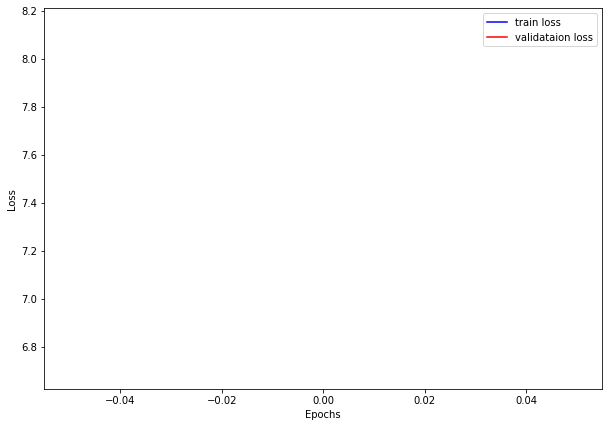

In [23]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

## Test Model

In [24]:
trained_model = torch.load(
    os.path.join(CHECKPOINT_DIR, 'model.pth')
)

In [25]:
# test_loss = validate(
#     trained_model, 
#     dataset_test,  
#     criterion, 
#     device
# )

# print(f"Test loss: {test_loss}")

## Text Generation

In [26]:
def return_int_vector(enc, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        return enc.encode(text)

In [27]:
enc = tiktoken.encoding_for_model("gpt2")

In [28]:
def sample_next(predictions, temperature=1.0):
    """
    Implement variable-temperature sampling from a probability
    distribution.
    """
    predictions = predictions.squeeze(0)[-1, :] / temperature
    predictions = predictions.exp().cpu()
    next_token = torch.multinomial(predictions, num_samples=1)
    return int(next_token[0].cpu())
    

def text_generator(sentence, generate_length):
    trained_model.eval()
    temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    num_tokens = len(sentence)
    for temeperature in temperatures:
        sample = sentence
        print(f"GENERATED SENTENCE WITH TEMPERATURE {temeperature}")
        for i in range(generate_length):
            int_vector = return_int_vector(enc, sample)
            input_tensor = torch.tensor(int_vector, dtype=torch.int32)
            input_tensor = input_tensor.unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            next_token = sample_next(predictions)
#             if next_token != 0: # Ignore <pad> index. Final sentence may be shorter.
            sample += ' ' + enc.decode([next_token])
        print(sample)
        print('\n')

In [29]:
generate_length = 128

In [30]:
sentences = [
    "Father Wolf began angrily--“By the Law of the Jungle he has no right to change his quarters without due warning."
]

In [31]:
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator(sentence, generate_length)
    print('\n############\n')

PROMPT: Father Wolf began angrily--“By the Law of the Jungle he has no right to change his quarters without due warning.
GENERATED SENTENCE WITH TEMPERATURE 0.1
Father Wolf began angrily--“By the Law of the Jungle he has no right to change his quarters without due warning. ,  might  were  Data  slog  shameless  he  width �  the s � Are  disruption  fingertips  Once  his s  It  a  consequential  M 
  fighting  holog 
  unnoticed ,  Oath  into �  about  Domestic Bernie  with �  and you  boy  was ,  was kie  saw  the �  campaigners the  the  disav 
 
  up  and . amp  the  chicken CHAR  at  of Moscow  grew ,  Serving  from . - spring ACK  jungle  St ually - b �  who  boosting  business  regulation  had  dreams ieri  geometric  the  to unknown  generators  IDF , 
  Forward tight , , 
 ,  is  say . ke , the  Iron over  time  Ukraine  and 
  she  Ballistic g  killed  and iger  is  darkness  head 
 , ow  sleep g  the ers  into � 



GENERATED SENTENCE WITH TEMPERATURE 0.2
Father Wolf began ang

thread '<unnamed>' panicked at 'no entry found for key', src/lib.rs:201:37
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: no entry found for key